
# How Has NBA Play Style Changed Over the Years? 📈🏀

**Dataset:** `Advanced.csv` (player-season advanced stats)  
**Goal:** Explore trends in shot selection, efficiency, and roles over time.  
**Deliverables:** Clear visuals, short interpretations, and takeaways.

---


In [1]:

# If running locally, make sure you have pandas and matplotlib installed.
# !pip install pandas matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)


## 1) Load & Quick Peek

In [3]:

DATA_PATH = "Advanced.csv"  # change if needed
df = pd.read_csv(DATA_PATH)
df.head()


,season,lg,player,player_id,age,team,pos,g,gs,mp,per,ts_percent,x3p_ar,f_tr,orb_percent,drb_percent,trb_percent,ast_percent,stl_percent,blk_percent,tov_percent,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp
0,2025,NBA,Precious Achiuwa,achiupr01,25.0,NYK,C,57,10.0,1170.0,13.6,0.530,0.110,0.211,10.0,21.0,15.5,6.2,2.0,3.3,11.2,14.9,0.7,1.7,2.3,0.095,-2.1,0.2,-1.9,0.0
1,2025,NBA,Steven Adams,adamsst01,31.0,HOU,C,58,3.0,794.0,16.6,0.541,0.012,0.557,21.8,22.0,21.9,10.9,1.3,3.2,20.6,13.6,1.0,1.3,2.3,0.137,0.0,0.3,0.3,0.5
2,2025,NBA,Bam Adebayo,adebaba01,27.0,MIA,C,78,78.0,2674.0,18.9,0.561,0.199,0.295,7.7,23.1,15.5,20.0,1.8,1.9,11.4,23.5,3.5,4.0,7.5,0.135,1.0,1.0,2.0,2.7
3,2025,NBA,Ochai Agbaji,agbajoc01,24.0,TOR,SG,64,45.0,1739.0,12.0,0.601,0.474,0.090,3.7,11.4,7.5,7.9,1.6,1.6,8.9,14.6,1.6,1.5,3.1,0.087,-0.9,0.2,-0.7,0.5
4,2025,NBA,Santi Aldama,aldamsa01,24.0,MEM,PF,65,16.0,1660.0,16.8,0.588,0.503,0.145,6.1,20.3,13.3,15.2,1.5,1.6,9.3,18.5,2.9,2.0,5.0,0.144,2.5,0.7,3.2,2.2


In [4]:

print("Rows:", len(df), "Cols:", df.shape[1])
df.dtypes


Rows: 32606 Cols: 30


season           int64
lg              object
player          object
player_id       object
age            float64
team            object
pos             object
g                int64
gs             float64
mp             float64
per            float64
ts_percent     float64
x3p_ar         float64
f_tr           float64
orb_percent    float64
drb_percent    float64
trb_percent    float64
ast_percent    float64
stl_percent    float64
blk_percent    float64
tov_percent    float64
usg_percent    float64
ows            float64
dws            float64
ws             float64
ws_48          float64
obpm           float64
dbpm           float64
bpm            float64
vorp           float64
dtype: object

## 2) Cleaning & Types

In [5]:

# Convert season to int (e.g., '2019-20' -> 2020). If already int, this will best-effort parse.
def season_to_year(s):
    try:
        if isinstance(s, (int, np.integer)): 
            return int(s)
        if "-" in str(s):
            # keep the ending year (e.g., 2019-20 -> 2020)
            left, right = str(s).split("-")
            right = right.strip()
            # if right has 2 digits, add century from left
            if len(right) == 2:
                century = left[:2]
                return int(century + right)
            return int(right)
        return int(s)
    except Exception:
        return np.nan

df["season_year"] = df["season"].apply(season_to_year)

# Ensure numeric columns are numeric (coerce errors)
num_cols = [
    "age","g","gs","mp","per","ts_percent","x3p_ar","f_tr","orb_percent","drb_percent","trb_percent",
    "ast_percent","stl_percent","blk_percent","tov_percent","usg_percent","ows","dws","ws","ws_48",
    "obpm","dbpm","bpm","vorp"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep NBA only (if multiple leagues present)
if "lg" in df.columns:
    before = len(df)
    df = df[df["lg"].isin(["NBA","ABA","BAA"]) | df["lg"].isna()].copy()
    after = len(df)
    print(f"Filtered leagues: {before}->{after}")
    
# Drop obvious duplicates (player+season+team+mp as heuristic)
df = df.drop_duplicates(subset=[c for c in ["player_id","player","season","team","mp"] if c in df.columns])

# Basic NaN report
nan_report = df[num_cols].isna().mean().sort_values(ascending=False).head(10)
nan_report


Filtered leagues: 32606->32606


gs             0.250107
x3p_ar         0.199196
tov_percent    0.176072
bpm            0.173342
dbpm           0.173342
obpm           0.173342
vorp           0.173189
usg_percent    0.173005
stl_percent    0.171962
blk_percent    0.171901
dtype: float64

## 3) Feature Engineering

In [6]:

# Minutes buckets for context
df["mp_bucket"] = pd.cut(df["mp"], bins=[0, 200, 500, 1000, 1500, 2000, 2500, 4000],
                         labels=["<200","200-500","500-1k","1k-1.5k","1.5k-2k","2k-2.5k","2.5k-4k"])

# Era buckets
def era(y):
    if pd.isna(y): return np.nan
    y=int(y)
    if y < 1980: return "Pre-3PT (<1980)"
    if y < 1990: return "1980s"
    if y < 2000: return "1990s"
    if y < 2010: return "2000s"
    if y < 2020: return "2010s"
    return "2020s"
df["era"] = df["season_year"].apply(era)

# Simplify positions (G/F/C)
if "pos" in df.columns:
    def pos_simple(p):
        if pd.isna(p): return np.nan
        p=str(p)
        if "C" in p: return "C"
        if "F" in p: return "F"
        if "G" in p: return "G"
        return p
    df["pos_simple"] = df["pos"].apply(pos_simple)

# Keep players with meaningful minutes for rate stability
df_core = df[df["mp"] >= 500].copy()
print("Core sample (mp>=500):", len(df_core))


Core sample (mp>=500): 21065



## 4) Research Questions

1. **Shot mix shift** — Did players attempt more threes over time? (`x3p_ar`)
2. **Free throws & rim pressure** — How has `f_tr` evolved?
3. **Efficiency** — Trend in `ts_percent` overall and by position?
4. **Usage & roles** — Changes in `usg_percent`, `ast_percent`, `trb_percent` over eras and positions.
5. **Impact metrics** — How do `bpm` and `vorp` trend for top players by era?


In [7]:

def line_by_year(group, y_col, ylabel=None, title=None):
    agg = (
        group.groupby("season_year")[y_col]
        .mean()
        .dropna()
        .reset_index()
        .sort_values("season_year")
    )
    plt.figure()
    plt.plot(agg["season_year"], agg[y_col])
    if title: plt.title(title)
    plt.xlabel("Season (year)") 
    plt.ylabel(ylabel or y_col)
    plt.grid(True)
    plt.show()
    return agg


### Q1) 3PT Attempt Rate Over Time (x3p_ar)

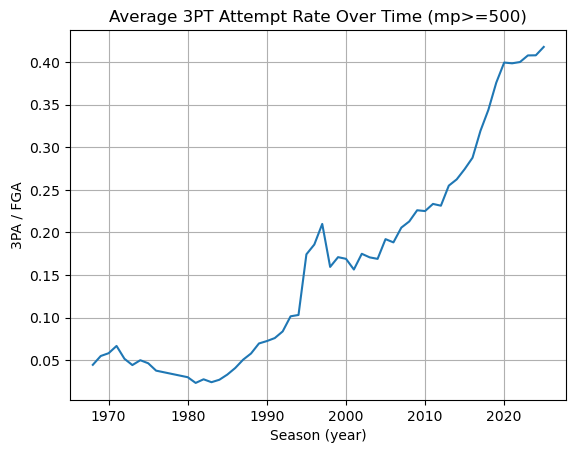

In [8]:

if "x3p_ar" in df_core.columns:
    _ = line_by_year(df_core, "x3p_ar", ylabel="3PA / FGA", title="Average 3PT Attempt Rate Over Time (mp>=500)")
else:
    print("x3p_ar not found")


### Q2) Free-Throw Rate (f_tr) Over Time

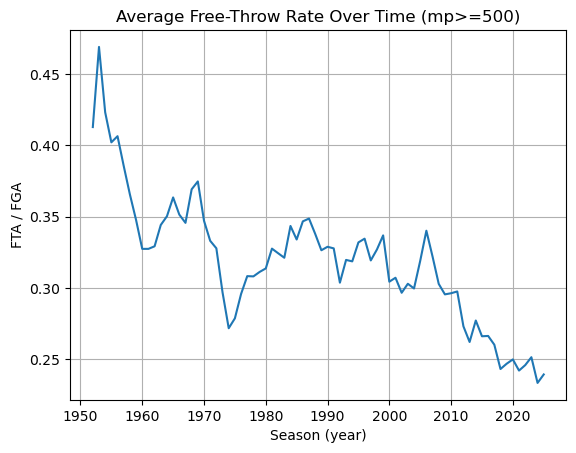

In [9]:

if "f_tr" in df_core.columns:
    _ = line_by_year(df_core, "f_tr", ylabel="FTA / FGA", title="Average Free-Throw Rate Over Time (mp>=500)")
else:
    print("f_tr not found")


### Q3) True Shooting% (ts_percent) — Overall and by Position

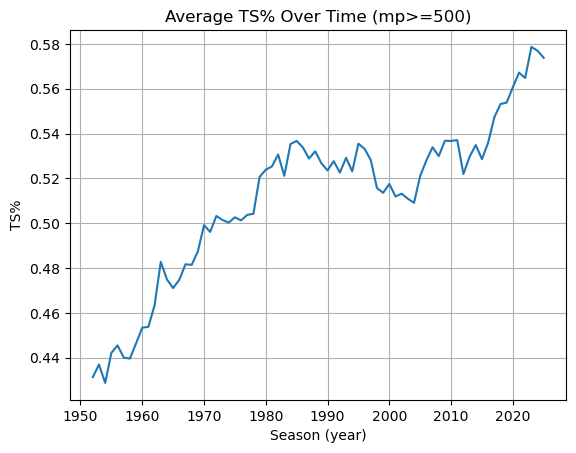

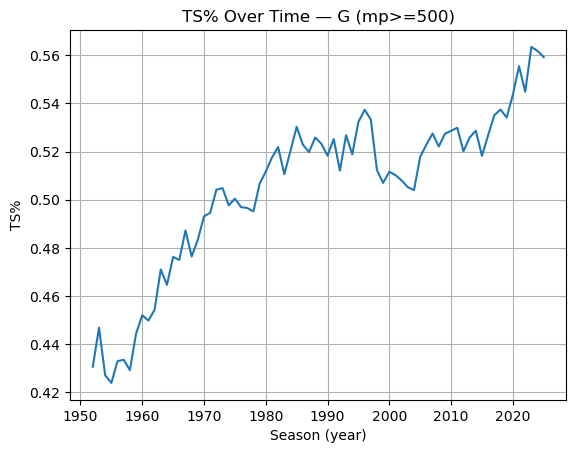

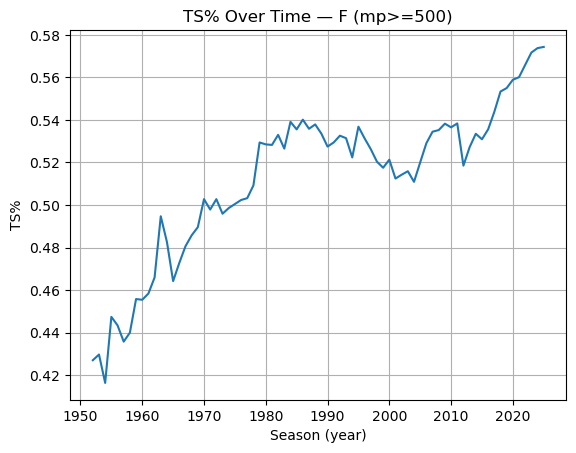

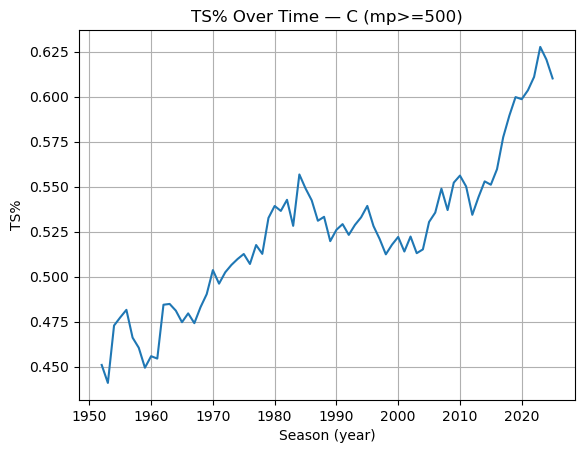

In [10]:

if "ts_percent" in df_core.columns:
    _ = line_by_year(df_core, "ts_percent", ylabel="TS%", title="Average TS% Over Time (mp>=500)")
    
    if "pos_simple" in df_core.columns:
        for p in ["G","F","C"]:
            sub = df_core[df_core["pos_simple"]==p]
            if len(sub)>0:
                _ = line_by_year(sub, "ts_percent", ylabel="TS%", title=f"TS% Over Time — {p} (mp>=500)")
else:
    print("ts_percent not found")


### Q4) Usage & Roles — `usg_percent`, `ast_percent`, `trb_percent` by Era & Position

In [11]:

metrics = [c for c in ["usg_percent","ast_percent","trb_percent"] if c in df_core.columns]
if metrics:
    pivot = (
        df_core.groupby(["era","pos_simple"])[metrics]
        .mean()
        .round(3)
        .reset_index()
        .sort_values(["era","pos_simple"])
    )
    pivot
else:
    print("No role metrics available among: usg_percent, ast_percent, trb_percent")


### Q5) Impact Metrics — Top Players per Era (BPM / VORP)

In [12]:

impact_cols = [c for c in ["bpm","vorp"] if c in df_core.columns]
if impact_cols:
    # per era: pick top-N by minutes, then show mean/max impact
    era_summary = []
    for e, g in df_core.groupby("era"):
        g = g.sort_values("mp", ascending=False).head(200)  # top 200 player-seasons by minutes each era
        rec = {"era": e}
        for c in impact_cols:
            rec[f"{c}_mean"] = g[c].mean()
            rec[f"{c}_p90"] = g[c].quantile(0.9)
            rec[f"{c}_max"] = g[c].max()
        era_summary.append(rec)
    era_df = pd.DataFrame(era_summary).sort_values("era")
    era_df
else:
    print("No impact metrics (bpm, vorp) found")


### Bonus) Age–Performance Curves by Era

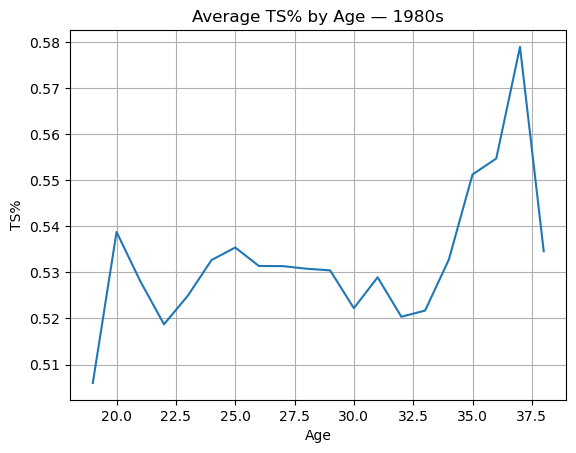

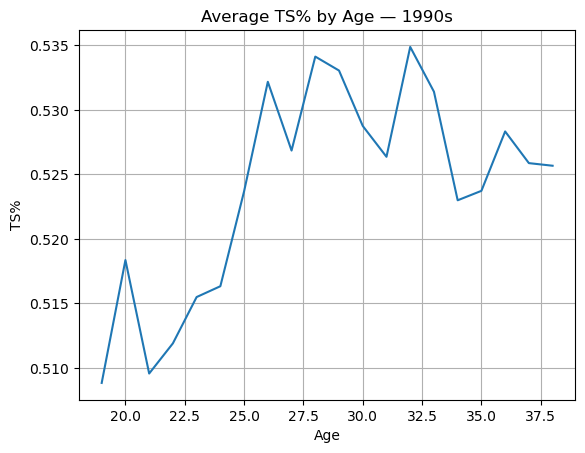

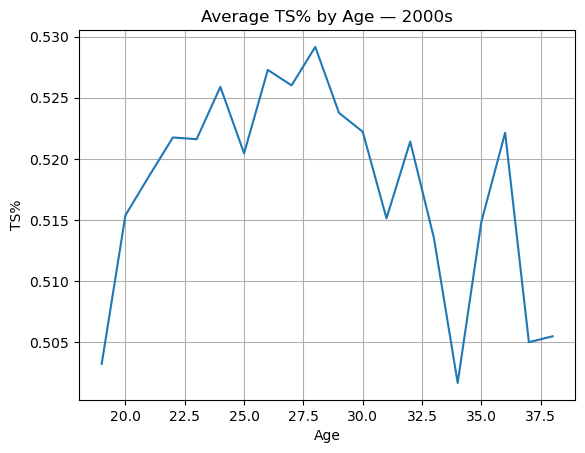

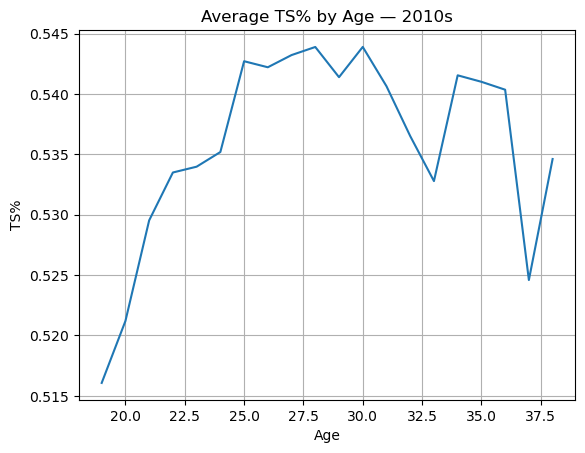

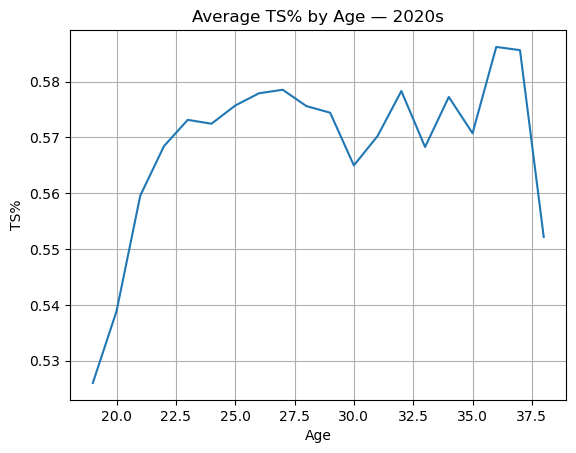

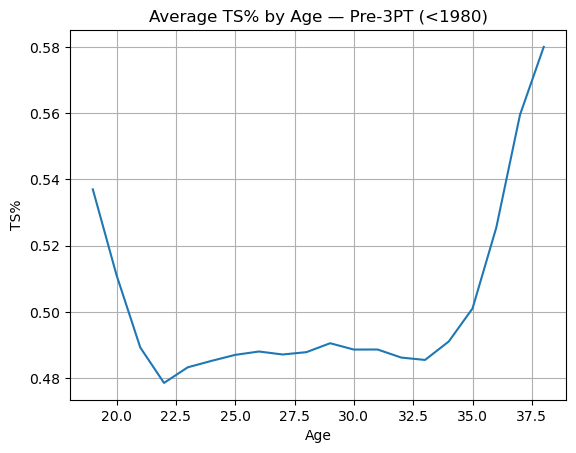

In [13]:

if all(c in df_core.columns for c in ["age","ts_percent"]):
    # Average TS% by age and era (to avoid clutter, keep common ages)
    sub = df_core[(df_core["age"] >= 19) & (df_core["age"] <= 38)]
    gp = sub.groupby(["era","age"])["ts_percent"].mean().reset_index()
    for e in gp["era"].dropna().unique():
        era_gp = gp[gp["era"]==e]
        if len(era_gp)>0:
            plt.figure()
            plt.plot(era_gp["age"], era_gp["ts_percent"])
            plt.title(f"Average TS% by Age — {e}")
            plt.xlabel("Age")
            plt.ylabel("TS%")
            plt.grid(True)
            plt.show()



## 6) Takeaways (fill after running the notebook)

- **3PT attempt rate** has _______ since the 1980s, indicating _______.
- **Free-throw rate** shows a _______ pattern, possibly due to _______.
- **Efficiency (TS%)** trends _______; by position, _______.
- **Roles (USG/AST/TRB)** indicate that _______.
- **Impact (BPM/VORP)**: top players in the _______ era reached _______.

> Tip: Add more visuals for specific players or teams you care about.
